In [ ]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive')

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [ ]:
!pip install nolds

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.1/225.1 kB 3.8 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
import numpy as np
import librosa
from scipy.signal import find_peaks

# Parameters
SAMPLE_RATE = 16000
DURATION = 15
MFCC_FEATURES = 13
SEGMENT_LENGTH = DURATION * SAMPLE_RATE
HOP_LENGTH = 128
FRAME_LENGTH = 256

def preprocess_audio(y, sample_rate=SAMPLE_RATE, segment_length=SEGMENT_LENGTH,
                   hop_length=HOP_LENGTH, n_mfcc=MFCC_FEATURES, frame_length=FRAME_LENGTH):
    """
    Extract comprehensive audio features from a single audio signal.

    Parameters:
    - y: Audio signal.
    - sample_rate: Sampling rate (default: 16000 Hz).
    - segment_length: Fixed length for audio segments (default: 15s * 16000).
    - hop_length: Hop length for STFT/MFCC (default: 128).
    - n_mfcc: Number of MFCC coefficients (default: 13).
    - frame_length: Frame length for envelope/crackle detection (default: 256).

    Returns:
    - Dictionary of extracted features or None if processing fails.
    """
    try:
        # Normalize and segment audio
        if len(y) < segment_length:
            y = np.pad(y, (0, segment_length - len(y)), mode='constant')
        else:
            y = y[:segment_length]
        y = y / (np.max(np.abs(y)) + 1e-10)  # Normalize

        features = {}

        # MFCC Features
        mfccs = librosa.feature.mfcc(y=y, sr=sample_rate, n_mfcc=n_mfcc, hop_length=hop_length, n_fft=frame_length)
        delta_mfccs = librosa.feature.delta(mfccs)
        for i in range(n_mfcc):
            features[f"mfcc_mean_{i}"] = float(np.mean(mfccs[i]))
            features[f"mfcc_var_{i}"] = float(np.var(mfccs[i]))
            features[f"delta_mfcc_{i}"] = float(np.mean(delta_mfccs[i]))

        # Spectral Features
        features["spectral_centroid"] = float(np.mean(librosa.feature.spectral_centroid(y=y, sr=sample_rate, hop_length=hop_length)[0]))
        features["spectral_rolloff"] = float(np.mean(librosa.feature.spectral_rolloff(y=y, sr=sample_rate, hop_length=hop_length)[0]))
        features["zero_crossing_rate"] = float(np.mean(librosa.feature.zero_crossing_rate(y, hop_length=hop_length)[0]))

        # STFT for frequency-based features
        stft = np.abs(librosa.stft(y, n_fft=frame_length, hop_length=hop_length))
        freqs = librosa.fft_frequencies(sr=sample_rate, n_fft=frame_length)

        # Crackle Features
        envelope = np.abs(librosa.util.frame(y, frame_length=frame_length, hop_length=hop_length).mean(axis=0))
        peaks, _ = find_peaks(envelope, height=np.mean(envelope) * 1.5, distance=50)
        features["crackle_count"] = int(len(peaks))
        features["crackle_duration"] = float(np.sum(envelope[peaks] > np.percentile(envelope, 90)) * hop_length / sample_rate if len(peaks) > 0 else 0.0)
        fine_crackle_mask = (freqs >= 1000) & (freqs < 1500)
        coarse_crackle_mask = (freqs >= 1500) & (freqs < 2000)
        features["fine_crackle_energy"] = float(np.mean(stft[fine_crackle_mask, :]**2) if np.any(fine_crackle_mask) else 0.0)
        features["coarse_crackle_energy"] = float(np.mean(stft[coarse_crackle_mask, :]**2) if np.any(coarse_crackle_mask) else 0.0)

        # Wheeze Features
        wheeze_mask = (freqs >= 400) & (freqs < 1500)
        wheeze_energy = np.mean(stft[wheeze_mask, :], axis=0)
        features["wheeze_high_ratio"] = float(np.sum(wheeze_energy > np.mean(wheeze_energy) * 2) / (wheeze_energy.size + 1e-10))
        features["wheeze_peak_freq"] = float(freqs[wheeze_mask][np.argmax(np.mean(stft[wheeze_mask, :], axis=1))] if np.any(wheeze_mask) else 0.0)
        features["wheeze_duration"] = float(np.sum(wheeze_energy > np.percentile(wheeze_energy, 75)) * hop_length / sample_rate)
        harmonic_energy = np.mean(stft[wheeze_mask, :]**2) if np.any(wheeze_mask) else 0.0
        features["wheeze_harmonic_ratio"] = float(harmonic_energy / (np.mean(stft**2) + 1e-10))

        # Rhonchi and Bronchial Features
        rhonchi_mask = (freqs >= 50) & (freqs < 150)
        bronchial_mask = (freqs >= 300) & (freqs < 600)
        features["rhonchi_energy"] = float(np.mean(stft[rhonchi_mask, :]**2) if np.any(rhonchi_mask) else 0.0)
        features["bronchial_energy"] = float(np.mean(stft[bronchial_mask, :]**2) if np.any(bronchial_mask) else 0.0)

        # Ventilator and Low-Band Energy
        ventilator_mask = (freqs >= 50) & (freqs < 200)
        features["ventilator_ratio"] = float(np.sum(np.mean(stft[ventilator_mask, :], axis=0) > 0.1) / (stft.shape[1] + 1e-10))
        features["energy_low_band"] = float(np.mean(stft[(freqs >= 100) & (freqs < 400), :]**2) if np.any((freqs >= 100) & (freqs < 400)) else 0.0)

        # Respiratory Rate
        envelope_smooth = librosa.util.normalize(np.convolve(envelope, np.ones(200)/200, mode='same'))
        breath_peaks, _ = find_peaks(envelope_smooth, distance=sample_rate//2, height=np.mean(envelope_smooth) * 0.8)
        features["respiratory_rate"] = float(len(breath_peaks) * (60 / DURATION) if len(breath_peaks) > 0 else 20.0)

        # Sound Intensity
        features["sound_intensity"] = float(np.mean(y**2))

        return features

    except Exception as e:
        print(f"Error processing audio: {e}")
        return None

def augment_audio(y, sr=SAMPLE_RATE):
    """
    Apply augmentations to raw audio signal.

    Parameters:
    - y: Input audio signal.
    - sr: Sampling rate.

    Returns:
    - List of augmented audio signals (including original).
    """
    augmented = [y]  # Include original

    # Pitch Shift
    y_pitch = librosa.effects.pitch_shift(y, sr=sr, n_steps=np.random.uniform(-2, 2))
    augmented.append(y_pitch)

    # Time Stretch
    y_stretch = librosa.effects.time_stretch(y, rate=np.random.uniform(0.8, 1.2))
    augmented.append(y_stretch)

    # Add Noise
    noise = np.random.normal(0, 0.005, len(y))
    y_noise = y + noise
    augmented.append(y_noise)

    # Volume Scaling
    y_volume = y * np.random.uniform(0.7, 1.3)
    augmented.append(y_volume)

    return augmented

def process_dataset(audio_dir, output_csv="/content/drive/MyDrive/processed_features_ld8.1.csv"):
    """
    Process all audio files in a directory, extracting features with augmentation and saving to CSV.

    Parameters:
    - audio_dir: Root directory with subfolders named by labels containing audio files.
    - output_csv: Path to save the output CSV.

    Returns:
    - DataFrame with extracted features.
    """
    features_list = []
    for root, _, files in os.walk(audio_dir):
        label = os.path.basename(root)
        for file in files:
            if file.endswith((".wav", ".mp3")):
                file_path = os.path.join(root, file)
                print(f"Extracting features from: {file_path}")
                try:
                    # Load audio
                    y, _ = librosa.load(file_path, sr=SAMPLE_RATE, mono=True)
                    # Apply augmentations
                    augmented_audios = augment_audio(y)
                    for i, aug_y in enumerate(augmented_audios):
                        aug_name = f"{file_path}_aug_{i}" if i > 0 else file_path
                        print(f"Processing augmented version: {aug_name}")
                        features = preprocess_audio(aug_y)
                        if features:
                            features["file_name"] = aug_name
                            features["label"] = label
                            features_list.append(features)
                        else:
                            print(f"Skipping {aug_name} due to processing error")
                except Exception as e:
                    print(f"Error loading {file_path}: {e}")

    df = pd.DataFrame(features_list)
    if not df.empty:
        # Standardize label names
        df["label"] = df["label"].replace({
            "pneumonia3": "pneumonia",
            "pneumonia patient": "pneumonia",
            "pleural effusion": "pleural",
            "pleural rub": "pleural"
        })
        df.to_csv(output_csv, index=False)
        print(f"Dataset saved to {output_csv}")
    else:
        print("No features extracted; output not saved.")
    return df

if __name__ == "__main__":
    audio_dir = "/content/drive/MyDrive/lung_dataset"  # Replace with your audio directory
    process_dataset(audio_dir)

Extracting features from: /content/drive/MyDrive/lung_dataset/Normal/normal lung sound.wav
Processing augmented version: /content/drive/MyDrive/lung_dataset/Normal/normal lung sound.wav


/usr/local/lib/python3.11/dist-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Processing augmented version: /content/drive/MyDrive/lung_dataset/Normal/normal lung sound.wav_aug_1
Processing augmented version: /content/drive/MyDrive/lung_dataset/Normal/normal lung sound.wav_aug_2
Processing augmented version: /content/drive/MyDrive/lung_dataset/Normal/normal lung sound.wav_aug_3
Processing augmented version: /content/drive/MyDrive/lung_dataset/Normal/normal lung sound.wav_aug_4
Extracting features from: /content/drive/MyDrive/lung_dataset/Normal/normal breath sound.wav
Processing augmented version: /content/drive/MyDrive/lung_dataset/Normal/normal breath sound.wav
Processing augmented version: /content/drive/MyDrive/lung_dataset/Normal/normal breath sound.wav_aug_1
Processing augmented version: /content/drive/MyDrive/lung_dataset/Normal/normal breath sound.wav_aug_2
Processing augmented version: /content/drive/MyDrive/lung_dataset/Normal/normal breath sound.wav_aug_3
Processing augmented version: /content/drive/MyDrive/lung_dataset/Normal/normal breath sound.wav_

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import joblib
import librosa
import warnings
warnings.filterwarnings("ignore")

# Enable eager execution
tf.config.run_functions_eagerly(True)

# Focal loss
def focal_loss(gamma=5.0, alpha=0.5):
    def focal_loss_fn(y_true, y_pred):
        y_true = tf.cast(tf.one_hot(tf.cast(y_true, tf.int32), depth=tf.shape(y_pred)[-1]), tf.float32)
        ce_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred, from_logits=False)
        p_t = tf.reduce_sum(y_true * y_pred, axis=-1)
        focal_weight = tf.pow(1.0 - p_t, gamma)
        return tf.reduce_mean(focal_weight * ce_loss * alpha)
    return focal_loss_fn

# Audio augmentation
def augment_audio(X, sr=16000, hop_length=128, raw_audio=None):
    if raw_audio is None:
        X_aug = []
        for x in X:
            X_aug.append(x)
            X_pitch = x * np.random.uniform(0.92, 1.08)  # ±8%
            X_aug.append(X_pitch)
            X_stretch = x * np.random.uniform(0.7, 1.3)
            X_aug.append(X_stretch)
        return np.array(X_aug)
    else:
        X_aug = []
        for y in raw_audio:
            X_aug.append(librosa.feature.mfcc(y=y, sr=sr, hop_length=hop_length, n_fft=1024).flatten()[:X.shape[1]])
            y_pitch = librosa.effects.pitch_shift(y, sr=sr, n_steps=np.random.uniform(-5, 5))
            X_aug.append(librosa.feature.mfcc(y=y_pitch, sr=sr, hop_length=hop_length, n_fft=1024).flatten()[:X.shape[1]])
            y_stretch = librosa.effects.time_stretch(y, rate=np.random.uniform(0.6, 1.4))
            X_aug.append(librosa.feature.mfcc(y=y_stretch, sr=sr, hop_length=hop_length, n_fft=1024).flatten()[:X.shape[1]])
        return np.array(X_aug)

# Load dataset
DATASET_PATH = "/content/drive/MyDrive/processed_features_ld8.1.csv"
data = pd.read_csv(DATASET_PATH)
print(f"Loaded dataset: {DATASET_PATH}")
print(f"Shape: {data.shape}")
print(f"Labels: {data['label'].unique()}")
print(f"Label counts:\n{data['label'].value_counts()}")

# Drop rows with missing values
data = data.dropna()
print(f"Shape after dropping NA: {data.shape}")

X = data.drop(columns=["file_name", "label"])
y = data["label"]

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
joblib.dump(label_encoder, "label_encoder17.pkl")
print(f"Encoded labels: {label_encoder.classes_}")

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
joblib.dump(scaler, "scaler17.pkl")
print(f"Feature count: {X_scaled.shape[1]}")

# SMOTE+ENN balancing
class_counts = np.bincount(y_encoded)
sampling_strategy = {i: max(count, 300) for i, count in enumerate(class_counts)}  # At least 300 per class
pneumonia_idx = label_encoder.transform(["pneumonia"])[0] if "pneumonia" in label_encoder.classes_ else None
if pneumonia_idx is not None:
    sampling_strategy[pneumonia_idx] = max(class_counts[pneumonia_idx], 500)  # At least 500 for pneumonia
n_neighbors = min(5, max(1, min(class_counts) - 1))
print(f"Sampling strategy: {sampling_strategy}")
print(f"k_neighbors: {n_neighbors}")

smote_enn = SMOTEENN(
    smote=SMOTE(random_state=42, k_neighbors=n_neighbors, sampling_strategy=sampling_strategy),
    enn=EditedNearestNeighbours(n_neighbors=3),  # Softer cleaning
    random_state=42,
    n_jobs=-1
)
try:
    X_scaled_balanced, y_encoded_balanced = smote_enn.fit_resample(X_scaled, y_encoded)
    print(f"Balanced dataset shape: {X_scaled_balanced.shape}")
    print(f"Balanced label counts: {np.bincount(y_encoded_balanced)}")
except ValueError as e:
    print(f"SMOTE+ENN error: {e}")
    print("Falling back to SMOTE only...")
    smote = SMOTE(random_state=42, k_neighbors=n_neighbors, sampling_strategy=sampling_strategy)
    X_scaled_balanced, y_encoded_balanced = smote.fit_resample(X_scaled, y_encoded)
    print(f"Balanced dataset shape (SMOTE): {X_scaled_balanced.shape}")
    print(f"Balanced label counts (SMOTE): {np.bincount(y_encoded_balanced)}")

# 80/10/10 split
X_temp, X_test, y_temp, y_test = train_test_split(
    X_scaled_balanced, y_encoded_balanced, test_size=0.1, random_state=42, stratify=y_encoded_balanced
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1111, random_state=42, stratify=y_temp
)
print(f"Train size: {X_train.shape[0]}, Validation size: {X_val.shape[0]}, Test size: {X_test.shape[0]}")

# Feature Selection (for selected features model)
rf_model = RandomForestClassifier(n_estimators=300, max_depth=20, random_state=42)
rf_model.fit(X_train, y_train)
rf_importance = pd.DataFrame({"Feature": X.columns, "RF_Importance": rf_model.feature_importances_})

et_model = ExtraTreesClassifier(n_estimators=300, max_depth=20, random_state=42)
et_model.fit(X_train, y_train)
et_importance = pd.DataFrame({"Feature": X.columns, "ET_Importance": et_model.feature_importances_})

xgb_model = xgb.XGBClassifier(n_estimators=300, max_depth=20, random_state=42, eval_metric="mlogloss")
xgb_model.fit(X_train, y_train)
xgb_importance = pd.DataFrame({"Feature": X.columns, "XGB_Importance": xgb_model.feature_importances_})

feature_importance = rf_importance.merge(et_importance, on="Feature").merge(xgb_importance, on="Feature")
feature_importance["Mean_Importance"] = feature_importance[["RF_Importance", "ET_Importance", "XGB_Importance"]].mean(axis=1)
feature_importance = feature_importance.sort_values(by="Mean_Importance", ascending=False)
print("Top 14 Features by Mean Importance:\n", feature_importance.head(14))

# Must-have features
must_have = ["crackle_count", "respiratory_rate", "wheeze_high_ratio", "wheeze_peak_freq",
             "fine_crackle_energy", "coarse_crackle_energy", "rhonchi_energy", "bronchial_energy",
             "wheeze_harmonic_ratio", "wheeze_duration", "crackle_duration"]
must_have = [feat for feat in must_have if feat in X.columns]
top_features = list(set(feature_importance["Feature"].head(14).tolist() + must_have))
print("Selected Features:", top_features)

# Subset data for selected features
top_indices = [X.columns.get_loc(feat) for feat in top_features]
X_train_top = X_train[:, top_indices]
X_val_top = X_val[:, top_indices]
X_test_top = X_test[:, top_indices]

# Data augmentation for selected features
X_train_top_aug = augment_audio(X_train_top, raw_audio=None)
y_train_aug = np.repeat(y_train, 3)
print(f"Augmented train size (selected features): {X_train_top_aug.shape[0]}")

# Data augmentation for full features
X_train_full_aug = augment_audio(X_train, raw_audio=None)
y_train_full_aug = np.repeat(y_train, 3)
print(f"Augmented train size (full features): {X_train_full_aug.shape[0]}")

# Convert to NumPy arrays
X_train_top_aug = np.array(X_train_top_aug)
y_train_aug = np.array(y_train_aug)
X_val_top = np.array(X_val_top)
y_val = np.array(y_val)
X_test_top = np.array(X_test_top)
y_test = np.array(y_test)
X_train_full_aug = np.array(X_train_full_aug)
y_train_full_aug = np.array(y_train_full_aug)
X_val = np.array(X_val)
X_test = np.array(X_test)

# Class weights
class_weights = {i: 1.0 for i in range(len(label_encoder.classes_))}
label_weight_map = {
    "COPD": 4.0,
    "pneumonia": 12.0,
    "pnuemonia pt on ventilator": 3.0,
    "pleural": 0.5,
    "Wheezing": 2.0,
    "Creptation": 4.0,
    "OtherSounds": 1.0,
    "Normal": 5.0,
    "Asthma": 2.0,
    "Bronchral": 2.0,
    "Crackles": 4.0,
    "rhonching": 9.0,
    "wheezing- copd": 0.1,
    "aortic": 1.0
}
for label, weight in label_weight_map.items():
    if label in label_encoder.classes_:
        idx = label_encoder.transform([label])[0]
        class_weights[idx] = weight
print("Class weights:", class_weights)

# MLP Model (Selected Features)
mlp_model = Sequential([
    Input(shape=(len(top_features),)),
    Dense(512, activation="relu", kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation="relu", kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(128, activation="relu", kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(len(label_encoder.classes_), activation="softmax")
])

optimizer = Adam(learning_rate=0.0001)
mlp_model.compile(optimizer=optimizer, loss=focal_loss(gamma=5.0, alpha=0.5), metrics=["accuracy"])
mlp_model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor="val_accuracy", patience=30, restore_best_weights=True, mode="max")
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-7)

# Train MLP (Selected Features)
history = mlp_model.fit(
    X_train_top_aug, y_train_aug,
    epochs=150,
    batch_size=64,
    validation_data=(X_val_top, y_val),
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights,
    verbose=1
)

# Evaluate MLP (Selected Features)
mlp_loss_val, mlp_accuracy_val = mlp_model.evaluate(X_val_top, y_val, verbose=0)
mlp_loss_test, mlp_accuracy_test = mlp_model.evaluate(X_test_top, y_test, verbose=0)
print(f"MLP (Selected Features) Validation Accuracy: {mlp_accuracy_val:.4f}")
print(f"MLP (Selected Features) Test Accuracy: {mlp_accuracy_test:.4f}")

mlp_predictions = np.argmax(mlp_model.predict(X_test_top, verbose=0), axis=1)
unique_labels_test = np.unique(y_test)
target_names_test = [label_encoder.classes_[label] for label in unique_labels_test]
print("MLP (Selected Features) Classification Report:\n", classification_report(y_test, mlp_predictions, target_names=target_names_test))
print("MLP (Selected Features) Confusion Matrix:\n", confusion_matrix(y_test, mlp_predictions))

# MLP Model (Full Features)
mlp_model_full = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(512, activation="relu", kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation="relu", kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(128, activation="relu", kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(len(label_encoder.classes_), activation="softmax")
])

optimizer_full = Adam(learning_rate=0.0001)  # Separate optimizer for full features
mlp_model_full.compile(optimizer=optimizer_full, loss=focal_loss(gamma=5.0, alpha=0.5), metrics=["accuracy"])
mlp_model_full.summary()

# Train MLP (Full Features)
history_full = mlp_model_full.fit(
    X_train_full_aug, y_train_full_aug,
    epochs=150,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights,
    verbose=1
)

# Evaluate MLP (Full Features)
mlp_loss_val_full, mlp_accuracy_val_full = mlp_model_full.evaluate(X_val, y_val, verbose=0)
mlp_loss_test_full, mlp_accuracy_test_full = mlp_model_full.evaluate(X_test, y_test, verbose=0)
print(f"MLP (Full Features) Validation Accuracy: {mlp_accuracy_val_full:.4f}")
print(f"MLP (Full Features) Test Accuracy: {mlp_accuracy_test_full:.4f}")

mlp_predictions_full = np.argmax(mlp_model_full.predict(X_test, verbose=0), axis=1)
print("MLP (Full Features) Classification Report:\n", classification_report(y_test, mlp_predictions_full, target_names=target_names_test))
print("MLP (Full Features) Confusion Matrix:\n", confusion_matrix(y_test, mlp_predictions_full))

# RF Evaluation (Selected Features)
rf_model.fit(X_train_top, y_train)
rf_pred = rf_model.predict(X_test_top)
print(f"RF (Selected Features) Test Accuracy: {accuracy_score(y_test, rf_pred):.4f}")
print("RF (Selected Features) Classification Report:\n", classification_report(y_test, rf_pred, target_names=target_names_test))
print("RF (Selected Features) Confusion Matrix:\n", confusion_matrix(y_test, rf_pred))

# RF Evaluation (Full Features)
rf_model_full = RandomForestClassifier(n_estimators=300, max_depth=20, random_state=42)
rf_model_full.fit(X_train, y_train)
rf_pred_full = rf_model_full.predict(X_test)
print(f"RF (Full Features) Test Accuracy: {accuracy_score(y_test, rf_pred_full):.4f}")
print("RF (Full Features) Classification Report:\n", classification_report(y_test, rf_pred_full, target_names=target_names_test))
print("RF (Full Features) Confusion Matrix:\n", confusion_matrix(y_test, rf_pred_full))

# ET Evaluation (Selected Features)
et_model.fit(X_train_top, y_train)
et_pred = et_model.predict(X_test_top)
print(f"ET (Selected Features) Test Accuracy: {accuracy_score(y_test, et_pred):.4f}")
print("ET (Selected Features) Classification Report:\n", classification_report(y_test, et_pred, target_names=target_names_test))
print("ET (Selected Features) Confusion Matrix:\n", confusion_matrix(y_test, et_pred))

# ET Evaluation (Full Features)
et_model_full = ExtraTreesClassifier(n_estimators=300, max_depth=20, random_state=42)
et_model_full.fit(X_train, y_train)
et_pred_full = et_model_full.predict(X_test)
print(f"ET (Full Features) Test Accuracy: {accuracy_score(y_test, et_pred_full):.4f}")
print("ET (Full Features) Classification Report:\n", classification_report(y_test, et_pred_full, target_names=target_names_test))
print("ET (Full Features) Confusion Matrix:\n", confusion_matrix(y_test, et_pred_full))

# XGB Tuning (Selected Features)
xgb_param_grid = {
    "max_depth": [10, 15],
    "learning_rate": [0.05, 0.1]
}
xgb_grid = GridSearchCV(
    xgb.XGBClassifier(n_estimators=300, random_state=42, eval_metric="mlogloss"),
    param_grid=xgb_param_grid,
    cv=3,
    scoring="accuracy",
    verbose=0
)
xgb_grid.fit(X_train_top, y_train)
xgb_model = xgb_grid.best_estimator_
xgb_pred = xgb_model.predict(X_test_top)
print(f"XGB (Selected Features) Test Accuracy: {accuracy_score(y_test, xgb_pred):.4f}")
print("XGB (Selected Features) Classification Report:\n", classification_report(y_test, xgb_pred, target_names=target_names_test))
print("XGB (Selected Features) Confusion Matrix:\n", confusion_matrix(y_test, xgb_pred))

# XGB Tuning (Full Features)
xgb_grid_full = GridSearchCV(
    xgb.XGBClassifier(n_estimators=300, random_state=42, eval_metric="mlogloss"),
    param_grid=xgb_param_grid,
    cv=3,
    scoring="accuracy",
    verbose=0
)
xgb_grid_full.fit(X_train, y_train)
xgb_model_full = xgb_grid_full.best_estimator_
xgb_pred_full = xgb_model_full.predict(X_test)
print(f"XGB (Full Features) Test Accuracy: {accuracy_score(y_test, xgb_pred_full):.4f}")
print("XGB (Full Features) Classification Report:\n", classification_report(y_test, xgb_pred_full, target_names=target_names_test))
print("XGB (Full Features) Confusion Matrix:\n", confusion_matrix(y_test, xgb_pred_full))

# Ensemble (Selected Features)
ensemble_pred = np.apply_along_axis(
    lambda x: np.bincount(x, weights=[0.10, 0.55, 0.25, 0.10]).argmax(),
    axis=0,
    arr=[mlp_predictions, rf_pred, et_pred, xgb_pred]
)
print(f"Ensemble (Selected Features) Test Accuracy: {accuracy_score(y_test, ensemble_pred):.4f}")
print("Ensemble (Selected Features) Classification Report:\n", classification_report(y_test, ensemble_pred, target_names=target_names_test))
print("Ensemble (Selected Features) Confusion Matrix:\n", confusion_matrix(y_test, ensemble_pred))

# Ensemble (Full Features)
ensemble_pred_full = np.apply_along_axis(
    lambda x: np.bincount(x, weights=[0.10, 0.55, 0.25, 0.10]).argmax(),
    axis=0,
    arr=[mlp_predictions_full, rf_pred_full, et_pred_full, xgb_pred_full]
)
print(f"Ensemble (Full Features) Test Accuracy: {accuracy_score(y_test, ensemble_pred_full):.4f}")
print("Ensemble (Full Features) Classification Report:\n", classification_report(y_test, ensemble_pred_full, target_names=target_names_test))
print("Ensemble (Full Features) Confusion Matrix:\n", confusion_matrix(y_test, ensemble_pred_full))

# Save models (Selected Features)
mlp_model.save("mlp_model_optimized_v17_selected.keras")
joblib.dump(rf_model, "rf_model_optimized_v17_selected.pkl")
joblib.dump(et_model, "et_model_optimized_v17_selected.pkl")
joblib.dump(xgb_model, "xgb_model_optimized_v17_selected.pkl")

# Save models (Full Features)
mlp_model_full.save("mlp_model_optimized_v17_full.keras")
joblib.dump(rf_model_full, "rf_model_optimized_v17_full.pkl")
joblib.dump(et_model_full, "et_model_optimized_v17_full.pkl")
joblib.dump(xgb_model_full, "xgb_model_optimized_v17_full.pkl")
print("Models saved: v17_selected and v17_full variants")

Loaded dataset: /content/drive/MyDrive/processed_features_ld8.1.csv
Shape: (3530, 58)
Labels: ['Normal' 'pneumonia' 'OtherSounds' 'pleural' 'rhonching' 'wheezing- copd'
 'Wheezing' 'Creptation' 'pnuemonia pt on ventilator' 'Asthma' 'Crackles'
 'COPD' 'aortic' 'Bronchral']
Label counts:
label
Creptation                    1075
Wheezing                       865
pneumonia                      335
OtherSounds                    320
rhonching                      260
COPD                           140
Normal                         120
pleural                        100
Crackles                        80
Bronchral                       70
wheezing- copd                  55
Asthma                          45
pnuemonia pt on ventilator      40
aortic                          25
Name: count, dtype: int64
Shape after dropping NA: (3530, 58)
Encoded labels: ['Asthma' 'Bronchral' 'COPD' 'Crackles' 'Creptation' 'Normal'
 'OtherSounds' 'Wheezing' 'aortic' 'pleural' 'pneumonia'
 'pnuemonia pt on ve

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │        13,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 14)             │         1,806 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 182,926 (714.55 KB)

 Trainable params: 181,134 (707.55 KB)

 Non-trainable params: 1,792 (7.00 KB)

Epoch 1/150
123/123 ━━━━━━━━━━━━━━━━━━━━ 22s 155ms/step - accuracy: 0.1231 - loss: 4.4937 - val_accuracy: 0.3466 - val_loss: 0.9234 - learning_rate: 1.0000e-04
Epoch 2/150
123/123 ━━━━━━━━━━━━━━━━━━━━ 17s 141ms/step - accuracy: 0.3411 - loss: 2.7185 - val_accuracy: 0.5307 - val_loss: 0.7214 - learning_rate: 1.0000e-04
Epoch 3/150
123/123 ━━━━━━━━━━━━━━━━━━━━ 20s 141ms/step - accuracy: 0.4090 - loss: 2.2557 - val_accuracy: 0.6442 - val_loss: 0.5875 - learning_rate: 1.0000e-04
Epoch 4/150
123/123 ━━━━━━━━━━━━━━━━━━━━ 21s 143ms/step - accuracy: 0.4718 - loss: 1.8599 - val_accuracy: 0.6994 - val_loss: 0.5193 - learning_rate: 1.0000e-04
Epoch 5/150
123/123 ━━━━━━━━━━━━━━━━━━━━ 20s 143ms/step - accuracy: 0.5046 - loss: 1.6774 - val_accuracy: 0.7331 - val_loss: 0.4868 - learning_rate: 1.0000e-04
Epoch 6/150
123/123 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - accuracy: 0.5290 - loss: 1.5234 - val_accuracy: 0.7546 - val_loss: 0.4623 - learning_rate: 1.0000e-04
Epoch 7/150
123/123 ━━━━━━━━━━━━━━━━━━━━

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 512)            │        29,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 14)             │         1,806 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,798 (776.55 KB)

 Trainable params: 197,006 (769.55 KB)

 Non-trainable params: 1,792 (7.00 KB)

Epoch 1/150
123/123 ━━━━━━━━━━━━━━━━━━━━ 19s 151ms/step - accuracy: 0.1380 - loss: 4.4515 - val_accuracy: 0.3620 - val_loss: 0.9343 - learning_rate: 1.0000e-04
Epoch 2/150
123/123 ━━━━━━━━━━━━━━━━━━━━ 17s 137ms/step - accuracy: 0.3296 - loss: 2.7722 - val_accuracy: 0.5399 - val_loss: 0.7145 - learning_rate: 1.0000e-04
Epoch 3/150
123/123 ━━━━━━━━━━━━━━━━━━━━ 17s 139ms/step - accuracy: 0.4176 - loss: 2.2410 - val_accuracy: 0.6166 - val_loss: 0.5902 - learning_rate: 1.0000e-04
Epoch 4/150
123/123 ━━━━━━━━━━━━━━━━━━━━ 18s 144ms/step - accuracy: 0.4758 - loss: 1.8875 - val_accuracy: 0.6840 - val_loss: 0.5301 - learning_rate: 1.0000e-04
Epoch 5/150
123/123 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.5148 - loss: 1.6867 - val_accuracy: 0.7331 - val_loss: 0.4987 - learning_rate: 1.0000e-04
Epoch 6/150
123/123 ━━━━━━━━━━━━━━━━━━━━ 21s 137ms/step - accuracy: 0.5452 - loss: 1.5303 - val_accuracy: 0.7730 - val_loss: 0.4715 - learning_rate: 1.0000e-04
Epoch 7/150
123/123 ━━━━━━━━━━━━━━━━━━━━

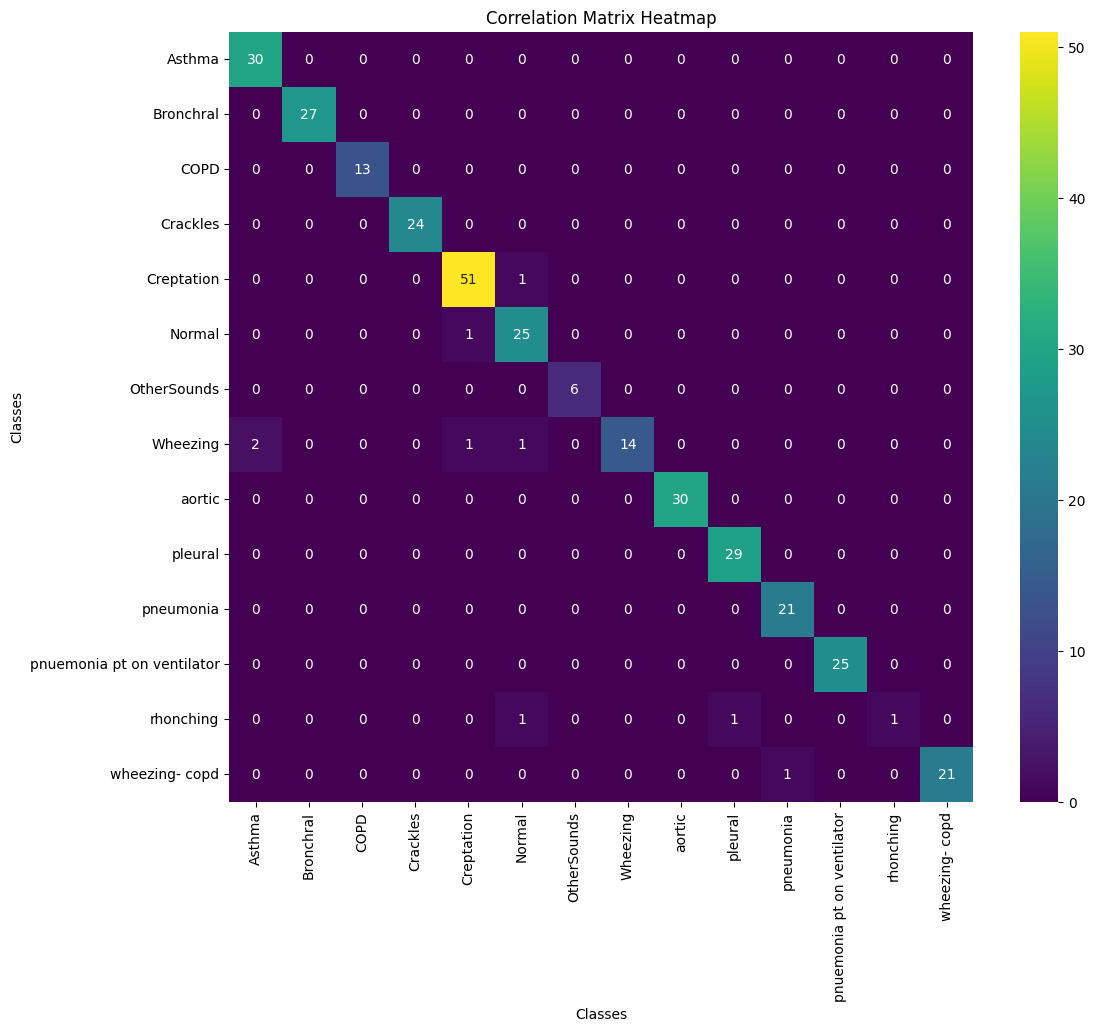

In [ ]:
# prompt:  [[30  0  0  0  0  0  0  0  0  0  0  0  0  0]
#  [ 0 27  0  0  0  0  0  0  0  0  0  0  0  0]
#  [ 0  0 13  0  0  0  0  0  0  0  0  0  0  0]
#  [ 0  0  0 24  0  0  0  0  0  0  0  0  0  0]
#  [ 0  0  0  0 51  1  0  0  0  0  0  0  0  0]
#  [ 0  0  0  0  1 25  0  0  0  0  0  0  0  0]
#  [ 0  0  0  0  0  0  6  0  0  0  0  0  0  0]
#  [ 2  0  0  0  1  1  0 14  0  0  0  0  0  0]
#  [ 0  0  0  0  0  0  0  0 30  0  0  0  0  0]
#  [ 0  0  0  0  0  0  0  0  0 29  0  0  0  0]
#  [ 0  0  0  0  0  0  0  0  0  0 21  0  0  0]
#  [ 0  0  0  0  0  0  0  0  0  0  0 25  0  0]
#  [ 0  0  0  0  0  1  0  0  0  1  0  0  1  0]
#  [ 0  0  0  0  0  0  0  0  0  0  1  0  0 21]]
# Asthma
# Bronchral
# COPD
# Crackles
# Creptation
# Normal
# OtherSounds
# Wheezing
# aortic
# pleural
# pneumonia
# pnuemonia pt on ventilator
# rhonching
# wheezing- copd
# these are classes make it as correlation matrix sns heatmap

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Data from your provided matrix
data = np.array([
    [30, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 27, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 24, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 51, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 25, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0],
    [2, 0, 0, 0, 1, 1, 0, 14, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 30, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 29, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 21, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 25, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 21]
])

# Class labels
classes = ["Asthma", "Bronchral", "COPD", "Crackles", "Creptation", "Normal", "OtherSounds", "Wheezing",
           "aortic", "pleural", "pneumonia", "pnuemonia pt on ventilator", "rhonching", "wheezing- copd"]

# Create the correlation matrix heatmap
plt.figure(figsize=(12, 10))  # Adjust figure size as needed
sns.heatmap(data, annot=True, fmt="d", cmap="viridis", xticklabels=classes, yticklabels=classes)
plt.title("Correlation Matrix Heatmap")
plt.xlabel("Classes")
plt.ylabel("Classes")
plt.show()


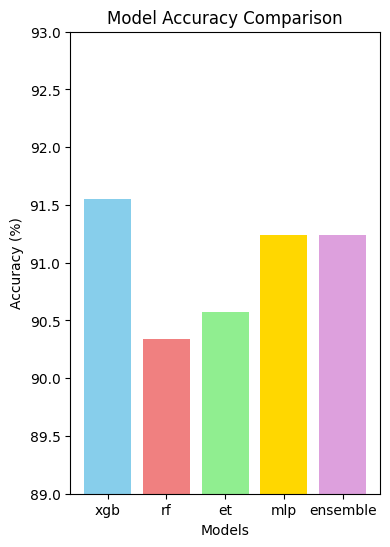

In [ ]:
# prompt: models accuracy is xgb-91.55,rf-90.34,et-90.57,mlp-91.24,ensemble-91.24
# give a bar plot with proper labels
# image ratio like phone

import matplotlib.pyplot as plt

models = ['xgb', 'rf', 'et', 'mlp', 'ensemble']
accuracy = [91.55, 90.34, 90.57, 91.24, 91.24]

plt.figure(figsize=(4, 6))  # Adjust for phone-like aspect ratio
plt.bar(models, accuracy, color=['skyblue', 'lightcoral', 'lightgreen', 'gold', 'plum'])
plt.xlabel("Models")
plt.ylabel("Accuracy (%)")
plt.title("Model Accuracy Comparison")
plt.ylim(89, 93) # Adjust y-axis limits for better visualization
plt.show()


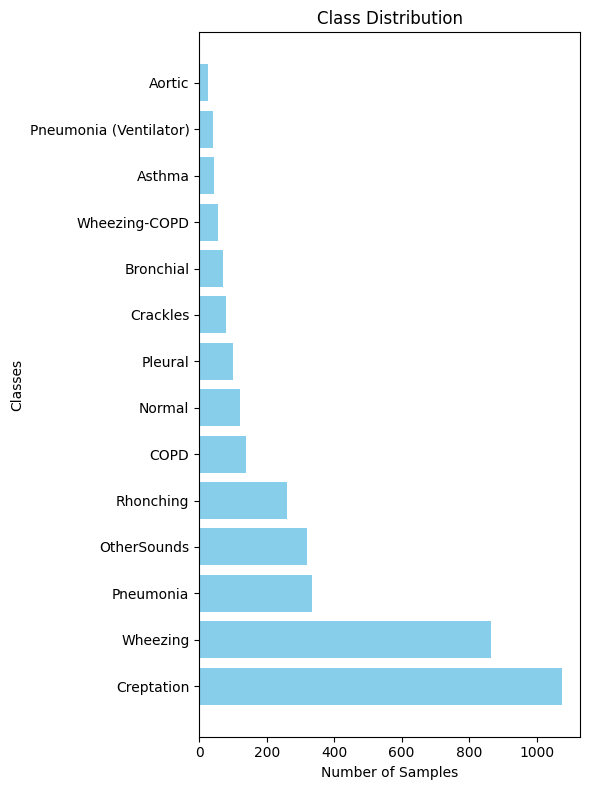

In [ ]:
# prompt: Class	Samples
# Creptation	1,075
# Wheezing	865
# Pneumonia	335
# OtherSounds	320
# Rhonching	260
# COPD	140
# Normal	120
# Pleural	100
# Crackles	80
# Bronchial	70
# Wheezing-COPD	55
# Asthma	45
# Pneumonia (Ventilator)	40
# Aortic	25
# give plot for this classes and their count
# image in vertical
# tight layout

import matplotlib.pyplot as plt

# Data from your provided text
classes = ['Creptation', 'Wheezing', 'Pneumonia', 'OtherSounds', 'Rhonching', 'COPD', 'Normal', 'Pleural', 'Crackles', 'Bronchial', 'Wheezing-COPD', 'Asthma', 'Pneumonia (Ventilator)', 'Aortic']
samples = [1075, 865, 335, 320, 260, 140, 120, 100, 80, 70, 55, 45, 40, 25]

# Create the plot
plt.figure(figsize=(6, 8)) # Adjust figure size for vertical orientation
plt.barh(classes, samples, color='skyblue')  # Horizontal bar plot
plt.xlabel('Number of Samples')
plt.ylabel('Classes')
plt.title('Class Distribution')
plt.tight_layout() # Adjust layout for better spacing
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')


# Load dataset
data = pd.read_csv('/content/drive/MyDrive/processed_features_ld8.1.csv')  # Update with your path
X = data.drop(columns=["file_name", "label"])
y = data["label"]

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Define minority and majority classes (example: minority < 50 samples)
class_counts = pd.Series(y).value_counts()
minority_classes = class_counts[class_counts < 50].index  # Adjust threshold
majority_classes = class_counts[class_counts >= 100].index

# Define sampling strategy: 50% for minority, 10% for majority
sampling_strategy = {}
for cls in label_encoder.classes_:
    cls_encoded = label_encoder.transform([cls])[0]
    original_count = class_counts[cls]
    if cls in minority_classes:
        sampling_strategy[cls_encoded] = int(original_count * 1.5)  # 50% more
    else:
        sampling_strategy[cls_encoded] = int(original_count * 1.1)  # 10% more

# Apply SMOTE
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_smote, y_smote = smote.fit_resample(X, y_encoded)

# Optionally apply ENN (light cleaning)
enn = EditedNearestNeighbours(n_neighbors=3)
X_balanced, y_balanced = enn.fit_resample(X_smote, y_smote)

# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
)

# Scale features (SVM is sensitive to scale)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train SVM
svm = SVC(
    kernel='rbf',           # Radial Basis Function kernel for non-linear data
    C=1.0,                  # Regularization parameter (controls margin vs. error)
    gamma='scale',          # Kernel coefficient (default: 1 / (n_features * X.var()))
    class_weight='balanced', # Adjust weights for class imbalance
    random_state=42,
    probability=True        # Enable probability estimates
)
svm.fit(X_train_scaled, y_train)

# Evaluate with cross-validation (prevent memorization)
cv_scores = cross_val_score(svm, X_train_scaled, y_train, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# Test on real data (assuming test set is real, non-synthetic)
y_pred = svm.predict(X_test_scaled)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test,y_pred,target_names=label_encoder.classes_))

# Save scaler for inference
import joblib
joblib.dump(scaler, 'svm_scaler.joblib')
joblib.dump(svm, 'svm_model.joblib')
print("Scaler and SVM model saved.")

Cross-Validation Accuracy: 0.7160 ± 0.0307
Test Accuracy: 0.6853448275862069

Classification Report:
                            precision    recall  f1-score   support

                    Asthma       0.33      1.00      0.50         1
                 Bronchral       1.00      1.00      1.00         7
                      COPD       1.00      1.00      1.00         1
                  Crackles       0.17      1.00      0.29         2
                Creptation       0.95      0.60      0.74       121
                    Normal       0.50      0.86      0.63         7
               OtherSounds       1.00      0.87      0.93        15
                  Wheezing       0.66      0.53      0.59        43
                    aortic       0.88      1.00      0.93         7
                   pleural       0.69      0.90      0.78        10
                 pneumonia       0.34      1.00      0.51        13
pnuemonia pt on ventilator       0.25      1.00      0.40         1
              

In [ ]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import joblib
import warnings
warnings.filterwarnings('ignore')

# Define focal loss for MLP (from your MLP script)
def focal_loss_fn(y_true, y_pred, alpha=0.25, gamma=2.0):
    y_true = tf.cast(y_true, tf.float32)
    ce = -y_true * tf.math.log(tf.clip_by_value(y_pred, 1e-7, 1.0))
    pt = tf.where(y_true == 1, y_pred, 1 - y_pred)
    focal_weight = alpha * tf.pow(1 - pt, gamma)
    loss = focal_weight * ce
    return tf.reduce_mean(tf.reduce_sum(loss, axis=-1))

# Define the 56 feature names (same as model 17 and MLP script)
feature_names = [
    f"mfcc_mean_{i}" for i in range(13)
] + [
    f"mfcc_var_{i}" for i in range(13)
] + [
    f"delta_mfcc_{i}" for i in range(13)
] + [
    "spectral_centroid", "spectral_rolloff", "zero_crossing_rate",
    "crackle_count", "crackle_duration", "fine_crackle_energy", "coarse_crackle_energy",
    "wheeze_high_ratio", "wheeze_peak_freq", "wheeze_duration", "wheeze_harmonic_ratio",
    "rhonchi_energy", "bronchial_energy", "ventilator_ratio", "energy_low_band",
    "respiratory_rate", "sound_intensity"
]

# Load dataset
data = pd.read_csv('/content/drive/MyDrive/processed_features_ld8.1.csv')  # Update with your path
X = data[feature_names].values
y = data['label'].values

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Define minority and majority classes (minority < 50 samples, adjust as needed)
class_counts = pd.Series(y).value_counts()
minority_classes = class_counts[class_counts < 50].index
majority_classes = class_counts[class_counts >= 50].index

# Define sampling strategy: 50% for minority, 10% for majority
sampling_strategy = {}
for cls in label_encoder.classes_:
    cls_encoded = label_encoder.transform([cls])[0]
    original_count = class_counts[cls]
    if cls in minority_classes:
        sampling_strategy[cls_encoded] = int(original_count * 1.5)  # 50% more
    else:
        sampling_strategy[cls_encoded] = int(original_count * 1.1)  # 10% more

# Apply SMOTE
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_smote, y_smote = smote.fit_resample(X, y_encoded)

# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_smote, y_smote, test_size=0.2, random_state=42, stratify=y_smote
)

# Scale features for MLP and SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
joblib.dump(scaler, 'scaler.joblib')

# Define and train models with grid search
models = {
    'MLP': {
        'model': None,  # Defined below due to Keras
        'param_grid': {
            'batch_size': [32, 64],
            'epochs': [50, 100]
        }
    },
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42, class_weight='balanced'),
        'param_grid': {
            'n_estimators': [100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }
    },
    'ExtraTrees': {
        'model': ExtraTreesClassifier(random_state=42, class_weight='balanced'),
        'param_grid': {
            'n_estimators': [100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=42, objective='multi:softmax', num_class=14, eval_metric='mlogloss'),
        'param_grid': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 6],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0]
        }
    },
    'SVM': {
        'model': SVC(random_state=42, class_weight='balanced', probability=True),
        'param_grid': {
            'C': [0.1, 1, 10],
            'kernel': ['rbf', 'linear'],
            'gamma': ['scale', 'auto']
        }
    }
}

# MLP model definition
def create_mlp():
    model = Sequential([
        Dense(512, activation='relu', input_shape=(56,)),
        Dropout(0.3),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(14, activation='softmax')
    ])
    model.compile(optimizer='adam', loss=focal_loss_fn, metrics=['accuracy'])
    return model

# Train and evaluate each model
for model_name, config in models.items():
    print(f"\nTraining {model_name}...")

    if model_name == 'MLP':
        # Train MLP with Keras
        model = create_mlp()
        best_score = 0
        best_params = {}
        for batch_size in config['param_grid']['batch_size']:
            for epochs in config['param_grid']['epochs']:
                history = model.fit(
                    X_train_scaled, tf.keras.utils.to_categorical(y_train, num_classes=14),
                    batch_size=batch_size, epochs=epochs, verbose=0,
                    validation_split=0.2
                )
                val_accuracy = max(history.history['val_accuracy'])
                if val_accuracy > best_score:
                    best_score = val_accuracy
                    best_params = {'batch_size': batch_size, 'epochs': epochs}
        # Retrain with best parameters
        model = create_mlp()
        model.fit(
            X_train_scaled, tf.keras.utils.to_categorical(y_train, num_classes=14),
            batch_size=best_params['batch_size'], epochs=best_params['epochs'], verbose=0
        )
        # Evaluate
        test_pred = model.predict(X_test_scaled, verbose=0)
        test_pred_classes = np.argmax(test_pred, axis=1)
        test_accuracy = accuracy_score(y_test, test_pred_classes)
        print(f"Validation Accuracy (Best): {best_score:.4f}")
        print(f"Test Accuracy: {test_accuracy:.4f}")
        config['model'] = model
    else:
        # Grid search for sklearn models
        grid = GridSearchCV(
            config['model'], config['param_grid'], cv=5, scoring='accuracy', n_jobs=-1
        )
        grid.fit(X_train_scaled if model_name in ['SVM'] else X_train, y_train)
        config['model'] = grid.best_estimator_
        print(f"Best parameters: {grid.best_params_}")
        cv_scores = cross_val_score(config['model'],
                                  X_train_scaled if model_name in ['SVM'] else X_train,
                                  y_train, cv=5)
        test_pred_classes = grid.predict(X_test_scaled if model_name in ['SVM'] else X_test)
        print(f"Cross-Validation Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
        print(f"Test Accuracy: {accuracy_score(y_test, test_pred_classes):.4f}")

    # Print classification report
    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_test, test_pred_classes,
                              target_names=label_encoder.classes_))

    # Save model
    if model_name == 'MLP':
        model.save(f'{model_name.lower()}_model.h5')
    else:
        joblib.dump(config['model'], f'{model_name.lower()}_model.joblib')
    print(f"{model_name} model saved.")

print("\nScaler saved as 'scaler.joblib'.")



Training MLP...


Validation Accuracy (Best): 0.7309
Test Accuracy: 0.6866

Classification Report for MLP:
                            precision    recall  f1-score   support

                    Asthma       0.20      0.08      0.11        13
                 Bronchral       0.87      0.87      0.87        15
                      COPD       0.45      0.16      0.24        31
                  Crackles       0.62      0.56      0.59        18
                Creptation       0.80      0.88      0.84       237
                    Normal       0.90      0.73      0.81        26
               OtherSounds       0.78      0.44      0.56        71
                  Wheezing       0.64      0.75      0.69       190
                    aortic       1.00      0.86      0.92         7
                   pleural       0.88      0.68      0.77        22
                 pneumonia       0.60      0.96      0.74        74
pnuemonia pt on ventilator       0.31      0.42      0.36        12
                 rhonching

In [ ]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import joblib
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')

# Mount Google Drive
drive.mount('/content/drive')

# Define focal loss for MLP
def focal_loss_fn(y_true, y_pred, alpha=0.25, gamma=2.0):
    y_true = tf.cast(y_true, tf.float32)
    ce = -y_true * tf.math.log(tf.clip_by_value(y_pred, 1e-7, 1.0))
    pt = tf.where(y_true == 1, y_pred, 1 - y_pred)
    focal_weight = alpha * tf.pow(1 - pt, gamma)
    loss = focal_weight * ce
    return tf.reduce_mean(tf.reduce_sum(loss, axis=-1))

# Define the 56 feature names
feature_names = [
    f"mfcc_mean_{i}" for i in range(13)
] + [
    f"mfcc_var_{i}" for i in range(13)
] + [
    f"delta_mfcc_{i}" for i in range(13)
] + [
    "spectral_centroid", "spectral_rolloff", "zero_crossing_rate",
    "crackle_count", "crackle_duration", "fine_crackle_energy", "coarse_crackle_energy",
    "wheeze_high_ratio", "wheeze_peak_freq", "wheeze_duration", "wheeze_harmonic_ratio",
    "rhonchi_energy", "bronchial_energy", "ventilator_ratio", "energy_low_band",
    "respiratory_rate", "sound_intensity"
]

# Load dataset
data = pd.read_csv('/content/drive/MyDrive/processed_features_ld8.1.csv')  # Update path
X = data[feature_names].values
y = data['label'].values

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Define minority and majority classes (minority < 50 samples)
class_counts = pd.Series(y).value_counts()
minority_classes = class_counts[class_counts < 50].index
majority_classes = class_counts[class_counts >= 50].index

# Define sampling strategy: 50% for minority, 10% for majority
sampling_strategy = {}
for cls in label_encoder.classes_:
    cls_encoded = label_encoder.transform([cls])[0]
    original_count = class_counts[cls]
    if cls in minority_classes:
        sampling_strategy[cls_encoded] = int(original_count * 1.5)  # 50% more
    else:
        sampling_strategy[cls_encoded] = int(original_count * 1.1)  # 10% more

# Apply SMOTE
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_smote, y_smote = smote.fit_resample(X, y_encoded)

# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_smote, y_smote, test_size=0.2, random_state=42, stratify=y_smote
)

# Scale features for MLP and SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
joblib.dump(scaler, '/content/drive/MyDrive/scaler.joblib')

# Define models with grid search
models = {
    'MLP': {
        'model': None,
        'param_grid': {
            'batch_size': [32, 64],
            'epochs': [50, 100]
        }
    },
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42, class_weight='balanced'),
        'param_grid': {
            'n_estimators': [100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }
    },
    'ExtraTrees': {
        'model': ExtraTreesClassifier(random_state=42, class_weight='balanced'),
        'param_grid': {
            'n_estimators': [100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=42, objective='multi:softmax', num_class=14, eval_metric='mlogloss'),
        'param_grid': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 6],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0]
        }
    },
    'SVM': {
        'model': SVC(random_state=42, class_weight='balanced', probability=True),
        'param_grid': {
            'C': [0.1, 1, 10],
            'kernel': ['rbf', 'linear'],
            'gamma': ['scale', 'auto']
        }
    }
}

# MLP model definition
def create_mlp():
    model = Sequential([
        Dense(512, activation='relu', input_shape=(56,)),
        Dropout(0.3),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(14, activation='softmax')
    ])
    model.compile(optimizer='adam', loss=focal_loss_fn, metrics=['accuracy'])
    return model

# Train and evaluate each model
for model_name, config in models.items():
    print(f"\nTraining {model_name}...")

    if model_name == 'MLP':
        # Train MLP with Keras
        model = create_mlp()
        best_score = 0
        best_params = {}
        for batch_size in config['param_grid']['batch_size']:
            for epochs in config['param_grid']['epochs']:
                history = model.fit(
                    X_train_scaled, tf.keras.utils.to_categorical(y_train, num_classes=14),
                    batch_size=batch_size, epochs=epochs, verbose=0,
                    validation_split=0.2
                )
                val_accuracy = max(history.history['val_accuracy'])
                if val_accuracy > best_score:
                    best_score = val_accuracy
                    best_params = {'batch_size': batch_size, 'epochs': epochs}
        # Retrain with best parameters
        model = create_mlp()
        model.fit(
            X_train_scaled, tf.keras.utils.to_categorical(y_train, num_classes=14),
            batch_size=best_params['batch_size'], epochs=best_params['epochs'], verbose=0
        )
        # Evaluate
        test_pred = model.predict(X_test_scaled, verbose=0)
        test_pred_classes = np.argmax(test_pred, axis=1)
        test_accuracy = accuracy_score(y_test, test_pred_classes)
        print(f"Validation Accuracy (Best): {best_score:.4f}")
        print(f"Test Accuracy: {test_accuracy:.4f}")
        config['model'] = model
    else:
        # Grid search for sklearn models
        # Optional: Use RandomizedSearchCV for faster runtime (uncomment below)
        from sklearn.model_selection import RandomizedSearchCV
        #grid = RandomizedSearchCV(config['model'], config['param_grid'], n_iter=10, cv=3, scoring='accuracy', n_jobs=-1)
        grid = GridSearchCV(config['model'], config['param_grid'], cv=5, scoring='accuracy', n_jobs=-1)
        #grid.fit(X_train_scaled if model_name in ['SVM'] else X_train, y_train)
        config['model'] = grid.best_estimator_
        print(f"Best parameters: {grid.best_params_}")
        cv_scores = cross_val_score(config['model'],
                                  X_train_scaled if model_name in ['SVM'] else X_train,
                                  y_train, cv=5)
        test_pred_classes = grid.predict(X_test_scaled if model_name in ['SVM'] else X_test)
        print(f"Cross-Validation Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
        print(f"Test Accuracy: {accuracy_score(y_test, test_pred_classes):.4f}")

    # Print classification report
    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_test, test_pred_classes,
                              target_names=label_encoder.classes_))

    # Save model to Google Drive
    if model_name == 'MLP':
        model.save(f'/content/drive/MyDrive/{model_name.lower()}_model.h5')
    else:
        joblib.dump(config['model'], f'/content/drive/MyDrive/{model_name.lower()}_model.joblib')
    print(f"{model_name} model saved.")

print("\nScaler saved as '/content/drive/MyDrive/scaler.joblib'.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Training MLP...


Validation Accuracy (Best): 0.7166
Test Accuracy: 0.7032

Classification Report for MLP:
                            precision    recall  f1-score   support

                    Asthma       0.38      0.62      0.47        13
                 Bronchral       1.00      0.80      0.89        15
                      COPD       0.42      0.52      0.46        31
                  Crackles       0.78      0.39      0.52        18
                Creptation       0.84      0.89      0.86       237
                    Normal       0.95      0.77      0.85        26
               OtherSounds       0.73      0.45      0.56        71
                  Wheezing       0.69      0.63      0.66       190
                    aortic       1.00      0.86      0.92         7
                   pleural       0.91      0.95      0.93        22
                 pneumonia       0.56      0.92      0.70        74
pnuemonia pt on ventilator       0.44      0.33      0.38        12
                 rhonching

KeyboardInterrupt: 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV,GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import joblib
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')

# Mount Google Drive
drive.mount('/content/drive')

# Define focal loss for MLP
def focal_loss_fn(y_true, y_pred, alpha=0.25, gamma=2.0):
    y_true = tf.cast(y_true, tf.float32)
    ce = -y_true * tf.math.log(tf.clip_by_value(y_pred, 1e-7, 1.0))
    pt = tf.where(y_true == 1, y_pred, 1 - y_pred)
    focal_weight = alpha * tf.pow(1 - pt, gamma)
    loss = focal_weight * ce
    return tf.reduce_mean(tf.reduce_sum(loss, axis=-1))

# Define the 56 feature names
feature_names = [
    f"mfcc_mean_{i}" for i in range(13)
] + [
    f"mfcc_var_{i}" for i in range(13)
] + [
    f"delta_mfcc_{i}" for i in range(13)
] + [
    "spectral_centroid", "spectral_rolloff", "zero_crossing_rate",
    "crackle_count", "crackle_duration", "fine_crackle_energy", "coarse_crackle_energy",
    "wheeze_high_ratio", "wheeze_peak_freq", "wheeze_duration", "wheeze_harmonic_ratio",
    "rhonchi_energy", "bronchial_energy", "ventilator_ratio", "energy_low_band",
    "respiratory_rate", "sound_intensity"
]

# Load dataset
data = pd.read_csv('/content/drive/MyDrive/processed_features_ld8.1.csv')  # Update path
X = data[feature_names].values
y = data['label'].values

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Define minority and majority classes (minority < 50 samples)
class_counts = pd.Series(y).value_counts()
minority_classes = class_counts[class_counts < 50].index
majority_classes = class_counts[class_counts >= 50].index

# Define sampling strategy: 75% for minority with <10 samples, 50% for others, 10% for majority
sampling_strategy = {}
for cls in label_encoder.classes_:
    cls_encoded = label_encoder.transform([cls])[0]
    original_count = class_counts[cls]
    if cls in minority_classes:
        sampling_strategy[cls_encoded] = int(original_count * 1.5)  # 50% more
    else:
        sampling_strategy[cls_encoded] = int(original_count * 1.1)

# Apply SMOTE
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_smote, y_smote = smote.fit_resample(X, y_encoded)

# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_smote, y_smote, test_size=0.2, random_state=42, stratify=y_smote
)

# Scale features for MLP and SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
joblib.dump(scaler, '/content/drive/MyDrive/scaler.joblib')

# Define models with randomized search
models = {
    'MLP': {
        'model': None,
        'param_grid': {
            'batch_size': [32, 64],
            'epochs': [100]  # Reduced for speed
        }
    },
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42, class_weight='balanced'),
        'param_grid': {
            'n_estimators': [100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }
    },
    'ExtraTrees': {
        'model': ExtraTreesClassifier(random_state=42, class_weight='balanced'),
        'param_grid': {
            'n_estimators': [100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=42, objective='multi:softmax', num_class=14, eval_metric='mlogloss'),
        'param_grid': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 6],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0]
        }
    }
}

# MLP model definition
def create_mlp():
    model = Sequential([
        Dense(512, activation='relu', input_shape=(56,)),  # All 56 features
        Dropout(0.3),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(14, activation='softmax')
    ])
    model.compile(optimizer='adam', loss=focal_loss_fn, metrics=['accuracy'])
    return model

# Train and evaluate each model
for model_name, config in models.items():
    print(f"\nTraining {model_name}...")

    if model_name == 'MLP':
        # Train MLP with Keras
        model = create_mlp()
        early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
        best_score = 0
        best_params = {}
        for batch_size in config['param_grid']['batch_size']:
            for epochs in config['param_grid']['epochs']:
                history = model.fit(
                    X_train_scaled, tf.keras.utils.to_categorical(y_train, num_classes=14),
                    batch_size=batch_size, epochs=epochs, verbose=0,
                    validation_split=0.2, callbacks=[early_stopping]
                )
                val_accuracy = max(history.history['val_accuracy'])
                if val_accuracy > best_score:
                    best_score = val_accuracy
                    best_params = {'batch_size': batch_size, 'epochs': epochs}
        # Retrain with best parameters
        model = create_mlp()
        model.fit(
            X_train_scaled, tf.keras.utils.to_categorical(y_train, num_classes=14),
            batch_size=best_params['batch_size'], epochs=best_params['epochs'], verbose=0,
            callbacks=[early_stopping]
        )
        # Evaluate
        test_pred = model.predict(X_test_scaled, verbose=0)
        test_pred_classes = np.argmax(test_pred, axis=1)
        test_accuracy = accuracy_score(y_test, test_pred_classes)
        print(f"Validation Accuracy (Best): {best_score:.4f}")
        print(f"Test Accuracy: {test_accuracy:.4f}")
        config['model'] = model
    else:
        # Randomized search for sklearn models
        #n_iter = 5 if model_name == 'SVM' else 10  # Fewer iterations for SVM
        grid = GridSearchCV(config['model'], config['param_grid'], cv=5, scoring='accuracy', n_jobs=-1)
        grid.fit(X_train_scaled if model_name in ['SVM'] else X_train, y_train)
        config['model'] = grid.best_estimator_
        print(f"Best parameters: {grid.best_params_}")
        print(f"Cross-Validation Accuracy: {grid.best_score_:.4f}")
        test_pred_classes = grid.predict(X_test_scaled if model_name in ['SVM'] else X_test)
        print(f"Test Accuracy: {accuracy_score(y_test, test_pred_classes):.4f}")

    # Print classification report
    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_test, test_pred_classes,
                              target_names=label_encoder.classes_))

    # Save model to Google Drive
    if model_name == 'MLP':
        model.save(f'/content/drive/MyDrive/{model_name.lower()}_model.h5')
    else:
        joblib.dump(config['model'], f'/content/drive/MyDrive/{model_name.lower()}_model.joblib')
    print(f"{model_name} model saved.")

print("\nScaler saved as '/content/drive/MyDrive/scaler.joblib'.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Training MLP...


Validation Accuracy (Best): 0.7134
Test Accuracy: 0.6803

Classification Report for MLP:
                            precision    recall  f1-score   support

                    Asthma       0.35      0.62      0.44        13
                 Bronchral       0.92      0.80      0.86        15
                      COPD       0.38      0.19      0.26        31
                  Crackles       0.54      0.39      0.45        18
                Creptation       0.83      0.88      0.85       237
                    Normal       0.87      0.77      0.82        26
               OtherSounds       0.83      0.48      0.61        71
                  Wheezing       0.64      0.54      0.59       190
                    aortic       1.00      0.86      0.92         7
                   pleural       0.87      0.91      0.89        22
                 pneumonia       0.61      0.93      0.74        74
pnuemonia pt on ventilator       0.38      0.75      0.50        12
                 rhonching

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import joblib
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')

# Mount Google Drive
drive.mount('/content/drive')

# Define focal loss for MLP
def focal_loss_fn(y_true, y_pred, alpha=0.25, gamma=2.0):
    y_true = tf.cast(y_true, tf.float32)
    ce = -y_true * tf.math.log(tf.clip_by_value(y_pred, 1e-7, 1.0))
    pt = tf.where(y_true == 1, y_pred, 1 - y_pred)
    focal_weight = alpha * tf.pow(1 - pt, gamma)
    loss = focal_weight * ce
    return tf.reduce_mean(tf.reduce_sum(loss, axis=-1))

# Define the 56 feature names
feature_names = [
    f"mfcc_mean_{i}" for i in range(13)
] + [
    f"mfcc_var_{i}" for i in range(13)
] + [
    f"delta_mfcc_{i}" for i in range(13)
] + [
    "spectral_centroid", "spectral_rolloff", "zero_crossing_rate",
    "crackle_count", "crackle_duration", "fine_crackle_energy", "coarse_crackle_energy",
    "wheeze_high_ratio", "wheeze_peak_freq", "wheeze_duration", "wheeze_harmonic_ratio",
    "rhonchi_energy", "bronchial_energy", "ventilator_ratio", "energy_low_band",
    "respiratory_rate", "sound_intensity"
]

# Load dataset
data = pd.read_csv('/content/drive/MyDrive/processed_features_ld8.1.csv')  # Update path
X = data[feature_names].values
y = data['label'].values

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
joblib.dump(label_encoder, '/content/drive/MyDrive/label_encoder.joblib')

# Define minority and majority classes (minority < 50 samples)
class_counts = pd.Series(y).value_counts()
minority_classes = class_counts[class_counts < 50].index
majority_classes = class_counts[class_counts >= 50].index

# Define sampling strategy: 100% for minority with <10 samples, 50% for others, 10% for majority
sampling_strategy = {}
for cls in label_encoder.classes_:
    cls_encoded = label_encoder.transform([cls])[0]
    original_count = class_counts[cls]
    if cls in minority_classes:
        if original_count < 10:  # Boost very small classes (e.g., Asthma, Aortic)
            sampling_strategy[cls_encoded] = int(original_count * 2.0)  # 100% more
        else:
            sampling_strategy[cls_encoded] = int(original_count * 1.5)  # 50% more
    else:
        sampling_strategy[cls_encoded] = int(original_count * 1.1)  # 10% more

# Apply SMOTE
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_smote, y_smote = smote.fit_resample(X, y_encoded)

# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_smote, y_smote, test_size=0.2, random_state=42, stratify=y_smote
)

# Scale features for MLP
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
joblib.dump(scaler, '/content/drive/MyDrive/scaler.joblib')

# Define models with randomized search
models = {
    'MLP': {
        'model': None,
        'param_grid': {
            'batch_size': [32, 64],
            'epochs': [50]  # Reduced for speed
        }
    },
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42, class_weight='balanced'),
        'param_grid': {
            'n_estimators': [100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }
    },
    'ExtraTrees': {
        'model': ExtraTreesClassifier(random_state=42, class_weight='balanced'),
        'param_grid': {
            'n_estimators': [100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=42, objective='multi:softmax', num_class=14, eval_metric='mlogloss'),
        'param_grid': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 6],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0]
        }
    }
}

# MLP model definition
def create_mlp():
    model = Sequential([
        Dense(512, activation='relu', input_shape=(56,)),  # All 56 features
        Dropout(0.3),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(14, activation='softmax')
    ])
    model.compile(optimizer='adam', loss=focal_loss_fn, metrics=['accuracy'])
    return model

# Train and evaluate each model
for model_name, config in models.items():
    print(f"\nTraining {model_name}...")

    if model_name == 'MLP':
        # Train MLP with Keras
        model = create_mlp()
        early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
        best_score = 0
        best_params = {}
        for batch_size in config['param_grid']['batch_size']:
            for epochs in config['param_grid']['epochs']:
                history = model.fit(
                    X_train_scaled, tf.keras.utils.to_categorical(y_train, num_classes=14),
                    batch_size=batch_size, epochs=epochs, verbose=0,
                    validation_split=0.2, callbacks=[early_stopping]
                )
                val_accuracy = max(history.history['val_accuracy'])
                if val_accuracy > best_score:
                    best_score = val_accuracy
                    best_params = {'batch_size': batch_size, 'epochs': epochs}
        # Retrain with best parameters
        model = create_mlp()
        model.fit(
            X_train_scaled, tf.keras.utils.to_categorical(y_train, num_classes=14),
            batch_size=best_params['batch_size'], epochs=best_params['epochs'], verbose=0,
            callbacks=[early_stopping]
        )
        # Evaluate
        test_pred = model.predict(X_test_scaled, verbose=0)
        test_pred_classes = np.argmax(test_pred, axis=1)
        test_accuracy = accuracy_score(y_test, test_pred_classes)
        print(f"Validation Accuracy (Best): {best_score:.4f}")
        print(f"Test Accuracy: {test_accuracy:.4f}")
        config['model'] = model
    else:
        # Randomized search for sklearn models
        grid = RandomizedSearchCV(
            config['model'], config['param_grid'], n_iter=10, cv=3, scoring='accuracy', n_jobs=-1, random_state=42
        )
        grid.fit(X_train, y_train)
        config['model'] = grid.best_estimator_
        print(f"Best parameters: {grid.best_params_}")
        print(f"Cross-Validation Accuracy: {grid.best_score_:.4f}")
        test_pred_classes = grid.predict(X_test)
        print(f"Test Accuracy: {accuracy_score(y_test, test_pred_classes):.4f}")

    # Print classification report
    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_test, test_pred_classes,
                              target_names=label_encoder.classes_))

    # Save model to Google Drive
    if model_name == 'MLP':
        model.save(f'/content/drive/MyDrive/{model_name.lower()}_model.keras')  # Updated to Keras format
    else:
        joblib.dump(config['model'], f'/content/drive/MyDrive/{model_name.lower()}_model.joblib')
    print(f"{model_name} model saved.")

print("\nScaler saved as '/content/drive/MyDrive/scaler.joblib'.")
print("Label encoder saved as '/content/drive/MyDrive/label_encoder.joblib'.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Training MLP...
Validation Accuracy (Best): 0.7229
Test Accuracy: 0.6892

Classification Report for MLP:
                            precision    recall  f1-score   support

                    Asthma       0.35      0.62      0.44        13
                 Bronchral       0.86      0.80      0.83        15
                      COPD       0.43      0.39      0.41        31
                  Crackles       0.69      0.50      0.58        18
                Creptation       0.80      0.88      0.84       237
                    Normal       0.91      0.77      0.83        26
               OtherSounds       0.73      0.42      0.54        71
                  Wheezing       0.72      0.55      0.63       190
                    aortic       0.86      0.86      0.86         7
                   pleural       0.90      0.82      0.86        22
                